# A Quantitative Evaluation of the European Commission´s Fiscal Governance Proposal

This notebook reproduces results of the Bruegel Working Paper "A Quantitative Evaluation of the European Commission´s Fiscal Governance Proposal" by Zsolt Darvas, Lennard Welslau, and Jeromin Zettelmeyer (2023). For details on the methodology see Annex II, "Methodology and code for implementing the European Commission´s DSA in the context of the economic governance review".

Note that for the analysis to run, data on growth, ageing costs, property income, interest and inflation expectations, and institutional debt has to be added to "../data/InputData/deterministic_model_data.xlsx". This data has been sourced directly from the European Commission, the ESM, and Bloomberg, and we have no permission to share it publicly.

For comments and suggestions please contact lennard.welslau[at]bruegel[dot]org.

In [18]:
# Import libraries and modules
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.3f}".format
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Import DSA model class and stochastic subclass
from EcDsaModelClass import EcDsaModel
from EcStochasticModelClass import EcStochasticModel

# Import functions for analysis loops and plots
from ec_dsa_functions import *

# Set autoreleoad
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example Cases
This section introduces some of the functionalities of the EcDsaModelClass and the EcStochasticModelClass.

### Deterministic Model Class

Initialize model with country ISO code and adjustment period length. For deterministic projections the parent class "EcDsaModel" can be used.

In [2]:
bel_dsa_model = EcDsaModel(country='BEL', adjustment_period=4)

Project the debt ratio forward, assuming linear adjustment to a structural primary balance target using the "project" method. \
To project the model under specific scenario assumptions, pass the scenario name as a string. Deterministic scenarios are "main_adjustment", "adverse_r_g", "financial_stress", and "lower_spb".

In [3]:
bel_dsa_model.project(spb_target=1, scenario='main_adjustment')

Show the resulting debt ratio and primary balance path using the "df" method. \
The "df" method takes strings of the model variables or a dictionary with model variables and desired column names as input argument and returns a pandas dataframe.

In [4]:
output_var_dict = {'d': 'Debt ratio', 'spb_bcoa': 'Ageing-cost adjusted structural primary balance', 'pb': 'Primary balance', 'ob':'Overall balance'}
output_df = bel_dsa_model.df(output_var_dict)
output_df.head(10)

,,Debt ratio,Ageing-cost adjusted structural primary balance,Primary balance,Overall balance
t,y,,,,
0,2022,105.129,-2.655,-2.365,NaN
1,2023,105.972,-3.138,-3.254,-4.690
2,2024,107.323,-2.504,-2.753,-4.725
3,2025,108.240,-1.628,-2.098,-4.364
4,2026,108.709,-0.752,-1.460,-3.963
5,2027,108.415,0.124,-0.688,-3.384
6,2028,107.338,1.000,0.187,-2.658
7,2029,105.511,1.000,0.426,-2.504
8,2030,103.854,1.000,0.656,-2.345


The "find_spb_deterministic" method finds the structural primary balance path so that specified criteria are met given scenario assumptions.

In [5]:
bel_dsa_model.find_spb_deterministic(scenario='adverse_r_g', criterion='debt_decline')

1.8309999999998334

The model is upodated automatically to the optimal SPB and we can plot the resulting debt ratio projection using the "df" method and build-in plotting function.

<Axes: title={'center': 'Debt ratio projection Belgium'}, xlabel='(t, Year)', ylabel='Debt ratio'>

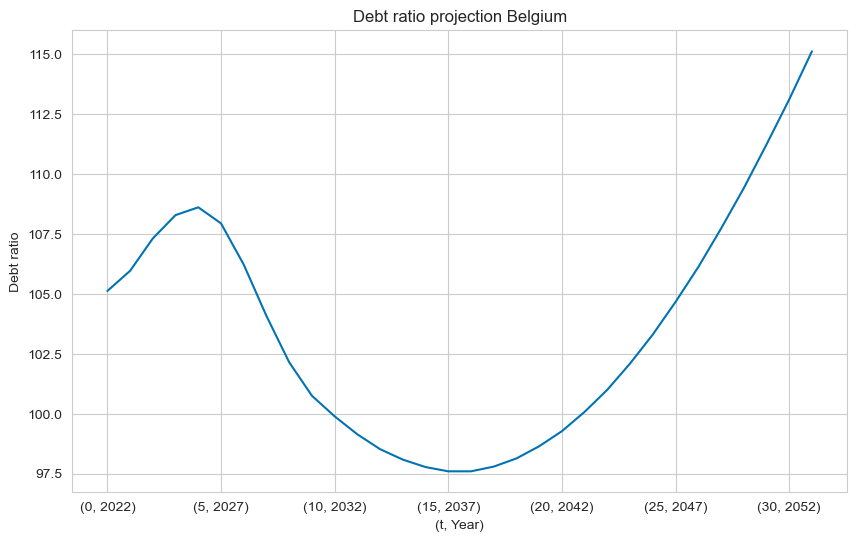

In [6]:
bel_dsa_model.df('d').plot(title='Debt ratio projection Belgium', ylabel='Debt ratio', xlabel='(t, Year)', legend=False, figsize=(10, 6))

### Stochastic Model Class

The Stochastic Model Class is a subclass of the EcDsaModels and inherits all its functionalities. It is initiated analogously.

In [7]:
esp_dsa_stochastic_model = EcStochasticModel(country='ESP', adjustment_period=7)

After projecting the debt path, the "simulate" method simulates N projections based on shocks to growth, interest rate, exchange rate, and primary balance.

In [8]:
esp_dsa_stochastic_model.project()
esp_dsa_stochastic_model.simulate(N=1000000)

The "find_spb_stochastic" method optimizes for the primary balance path that ensures no more than 30% of simulated debt ratio paths are increasing.

In [9]:
esp_dsa_stochastic_model.find_spb_stochastic(prob_target=0.3)

1.9063751597924008

The "fanchart" method plots the percentiles of the simulated distribution of the debt ratio.

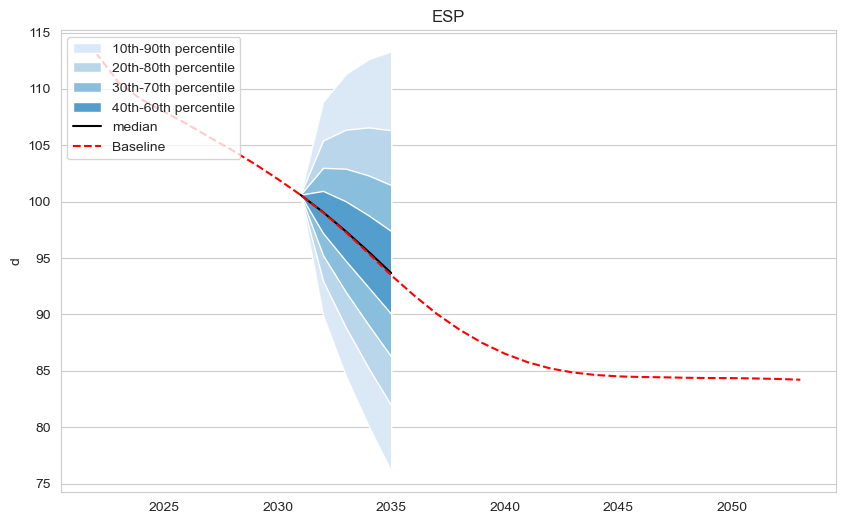

In [10]:
esp_dsa_stochastic_model.fanchart(variable='d')

The "find_spb_deficit" method optimizes for the structural primary balance that ensures a decline in the debt ratio after reaching a deficit below 3%.

In [11]:
esp_dsa_stochastic_model = EcStochasticModel(country='ESP', adjustment_period=7)
spb_deficit_safeguard = esp_dsa_stochastic_model.find_spb_deficit()
spb_deficit_safeguard

Deficit periods: 3
spb_initial_adjustment_step 0.5
ESP spb_target: {'main_adjustment': 1.178799999999832, 'lower_spb': 1.674299999999833, 'financial_stress': 1.178999999999832, 'adverse_r_g': 1.9873999999998329, 'deficit_reduction': 1.4565999999998325, 'debt_safeguard': 0.4214999999998323, 'stochastic': 1.9030335874813138}


1.9873999999998329

In [12]:
output_df = esp_dsa_stochastic_model.df(output_var_dict)
output_df['Annual adjustment'] = output_df['Ageing-cost adjusted structural primary balance'].diff()
output_df.head(10)

,,Debt ratio,Ageing-cost adjusted structural primary balance,Primary balance,Overall balance,Annual adjustment
t,y,,,,,
0,2022,113.216,-1.571,-2.425,NaN,NaN
1,2023,110.581,-1.229,-1.589,-3.907,0.342
2,2024,109.073,-0.767,-0.885,-3.317,0.462
3,2025,108.012,-0.267,-0.571,-3.264,0.500
4,2026,106.844,0.233,-0.183,-3.080,0.500
5,2027,105.445,0.733,0.279,-2.782,0.500
6,2028,103.876,1.047,0.674,-2.515,0.314
7,2029,102.298,1.360,1.042,-2.249,0.314
8,2030,100.714,1.674,1.381,-1.989,0.314


The "find_deficit_prob" method builds on the stochastic model to calculate the probabilites of an excessive deficit in each year of the adjustment period. \
It requires the specification of an adjustment path by passing aa structural primary balance target, and optionally, the number and step size of initial periods under deficit procedure. 

Text(0.5, 1.0, 'Probability of deficit during 7-year adjustment Spain')

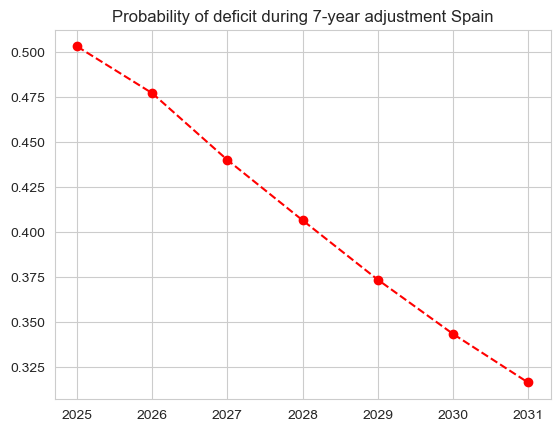

In [13]:
prob_deficit = esp_dsa_stochastic_model.find_deficit_prob(spb_target=1.9473, spb_initial_adjustment_period=3, spb_initial_adjustment_step=0.5)
plt.plot(np.arange(2025, 2032), prob_deficit, marker='o', linestyle='--', color='red')
plt.title('Probability of deficit during 7-year adjustment Spain')

Finally, the "find_spb_post_debt_safeguard" is a method that finds the strucutral primary balance needed to both satsify the debt safeguard over the first four years and satisfies all other criteria over the next three years. This method is needed to test 7-year adjustment cases in which the average adjustment over the first four years does not satisfy the debt safeguard.

In [14]:
bel_stochastic_model = EcStochasticModel(country='BEL', adjustment_period=7)
bel_stochastic_model.find_spb_post_debt_safeguard()

BEL spb target: {'main_adjustment': 1.0827999999998326, 'lower_spb': 1.5846999999998328, 'financial_stress': 1.0829999999998325, 'adverse_r_g': 1.9015999999998334, 'deficit_reduction': 1.4055999999998325, 'stochastic': 1.667108348374147}


1.9015999999998334

In [15]:
output_df = bel_stochastic_model.df(output_var_dict)
output_df['Annual adjustment'] = output_df['Ageing-cost adjusted structural primary balance'].diff()
output_df.head(10)

,,Debt ratio,Ageing-cost adjusted structural primary balance,Primary balance,Overall balance,Annual adjustment
t,y,,,,,
0,2022,105.129,-2.655,-2.365,NaN,NaN
1,2023,105.972,-3.138,-3.254,-4.690,-0.484
2,2024,107.323,-2.504,-2.753,-4.725,0.635
3,2025,108.241,-1.625,-2.096,-4.362,0.879
4,2026,108.708,-0.746,-1.457,-3.960,0.879
5,2027,108.409,0.133,-0.682,-3.378,0.879
6,2028,107.323,1.011,0.196,-2.649,0.879
7,2029,105.398,1.308,0.760,-2.176,0.297
8,2030,103.314,1.605,1.235,-1.765,0.297


## Run scenario analysis

This section calcualtes optimal primary balances and addiitonal model variables under different scenarios. These variables are saved in a results dictionary, which is subsequently used to assess the applicability of additional safeguards, select the binding scenario, and prepare result figures.

### Define variables

In [19]:
today = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')

eu_code_dict = {
    'AUT': 'Austria',
    'BEL': 'Belgium',
    'CYP': 'Cyprus',
    'CZE': 'Czech Republic',
    'DEU': 'Germany',
    'DNK': 'Denmark',
    'ESP': 'Spain',
    'FIN': 'Finland',
    'FRA': 'France',
    'GRC': 'Greece',
    'HRV': 'Croatia',
    'HUN': 'Hungary',
    'IRL': 'Ireland',
    'ITA': 'Italy',
    'NLD': 'Netherlands',
    'POL': 'Poland',
    'PRT': 'Portugal',
    'ROU': 'Romania',
    'SVK': 'Slovakia',
    'SVN': 'Slovenia',
    'SWE': 'Sweden',
    'BGR': 'Bulgaria',
    'MLT': 'Malta',
    'LTU': 'Lithuania',
    'LVA': 'Latvia'
}

eu_codes = list(eu_code_dict.keys())

var_list = [
    'rg', # real GDP growth
    'rg_pot', # potential real GDP growth
    'ng',  # nominal GDP growth
    'output_gap', # output gap
    'pi', # inflation
    'rgdp_pot', # potential real GDP
    'rgdp', # real GDP
    'ngdp', # nominal GDP
    'i_st', # short-term interest rate
    'i_lt', # long-term interest rate
    'iir_lt', # implicit long-term interest rate
    'iir', # implicit interest rate
    'sf', # stock flow adjustment
    'ageing_cost', # ageing cost
    'ageing_component', # ageing component of primary balance
    'cyclical_component', # cyclical component of primary balance
    'spb_bcoa', # ageing-cost adjusted structural primary balance
    'pb', # primary balance
    'pb_cyclical_adj', # cyclically adjusted primary balance
    'pb_cyclical_ageing_adj', # cyclically and ageing-cost adjusted primary balance
    'ob', # overall balance
    'd', # debt ratio
    'D', # debt level
    'D_lt_inst', # long-term instirutional debt level 
    'D_st', # short-term debt level
    'D_lt', # long-term debt level
    'amortization', # amortization
    'amortization_lt', # long-term amortization
    'amortization_lt_inst' # long-term institutional amortization
    ]

# Set path
if not os.path.exists(f'../output/{today}'):
    os.makedirs(f'../output/{today}')
if not os.path.exists(f'../output/{today}/fancharts'):
    os.makedirs(f'../output/{today}/fancharts') 
if not os.path.exists(f'../output/{today}/results_charts'):
    os.makedirs(f'../output/{today}/results_charts')       
output_path = f'../output/{today}'

In [20]:
# Initialize results dictionary
results_dict = {}
for country in eu_codes:
    results_dict[country] = {}
    for adjustment_period in [4, 7]:
        results_dict[country][adjustment_period] = {}

### Find optimal structural primary balances for deterministic scenarios

In [21]:
run_deterministic_scenario_loop(eu_codes, results_dict, var_list)

### Find optimal structural primary balances for stochastic scenarios

In [22]:
run_stochastic_scenario_loop(eu_codes, results_dict, output_path, var_list, today)

### Find optimal structural primary balances after a binding debt safeguard in the 7-year scenario

In [23]:
run_post_debt_safeguard_loop(results_dict, var_list)

Calculating optimal spb for BEL 7 1.9263999999998331 from adverse_r_g
BEL spb target: {'main_adjustment': 1.0827999999998326, 'lower_spb': 1.5846999999998328, 'financial_stress': 1.0829999999998325, 'adverse_r_g': 1.9015999999998334, 'deficit_reduction': 1.4055999999998325, 'stochastic': 1.666868556697527}
Calculating optimal spb for FRA 7 2.335999999999817 from debt_safeguard
FRA spb target: {'main_adjustment': 0.35589999999983174, 'lower_spb': 0.31919999999983134, 'financial_stress': 0.35589999999983174, 'adverse_r_g': 0.896999999999832, 'deficit_reduction': 0.3671999999998316, 'stochastic': 0.7824051305492656}
Calculating optimal spb for NLD 7 0.26189999999983193 from deficit_reduction
Calculating optimal spb for ROU 7 1.207999999999832 from deficit_reduction
ROU spb target: {'main_adjustment': -0.1790000000001679, 'lower_spb': 0.18689999999983148, 'financial_stress': -0.1790000000001679, 'adverse_r_g': 0.15719999999983142, 'deficit_reduction': 1.149299999999832, 'stochastic': 0.486

### Find optimal structural primary balances for binding deficit safeguard scenarios

In [24]:
run_deficit_safeguard_loop(results_dict, var_list)

Calculating optimal spb for ESP 7 1.9994999999998324 from adverse_r_g
Deficit periods: 3
spb_initial_adjustment_step 0.5
ESP spb_target: {'main_adjustment': 1.178799999999832, 'lower_spb': 1.674299999999833, 'financial_stress': 1.178999999999832, 'adverse_r_g': 1.9873999999998329, 'deficit_reduction': 1.4565999999998325, 'debt_safeguard': 0.4214999999998323, 'stochastic': 1.8982519816241976}
Calculating optimal spb for HUN 7 3.8349280048763505 from stochastic
Deficit periods: 4
spb_initial_adjustment_step 0.5
HUN spb_target: {'main_adjustment': 2.6442999999998067, 'lower_spb': 2.9976999999998064, 'financial_stress': 2.6441999999998065, 'adverse_r_g': 3.045599999999801, 'deficit_reduction': 2.9622999999997957, 'debt_safeguard': 1.5918999999998331, 'stochastic': 3.8170756240674715}
Calculating optimal spb for ITA 7 2.6828999999998024 from deficit_reduction
Deficit periods: 6
spb_initial_adjustment_step 0.5
ITA spb_target: {'main_adjustment': 1.693899999999833, 'lower_spb': 1.920699999999

### Run scenarios with baseline assumptions and binding structural primary balance

In [25]:
run_binding_baseline_loop(results_dict, var_list)

### Find the probability of excessive deficit during the adjustment period

In [26]:
deficit_prob_dict = run_deficit_prob_loop(results_dict)

### Save results to output folder

In [27]:
save_deficit_prob(deficit_prob_dict, output_path, today)
save_timeseries(results_dict, output_path, today)
save_spbstar(results_dict, output_path, today)
save_fancharts(results_dict, output_path, today)

## Figures

### Figure 2: Four-year adjustment under baseline and adverse r-g scenarios for Belgium, 2022-2050

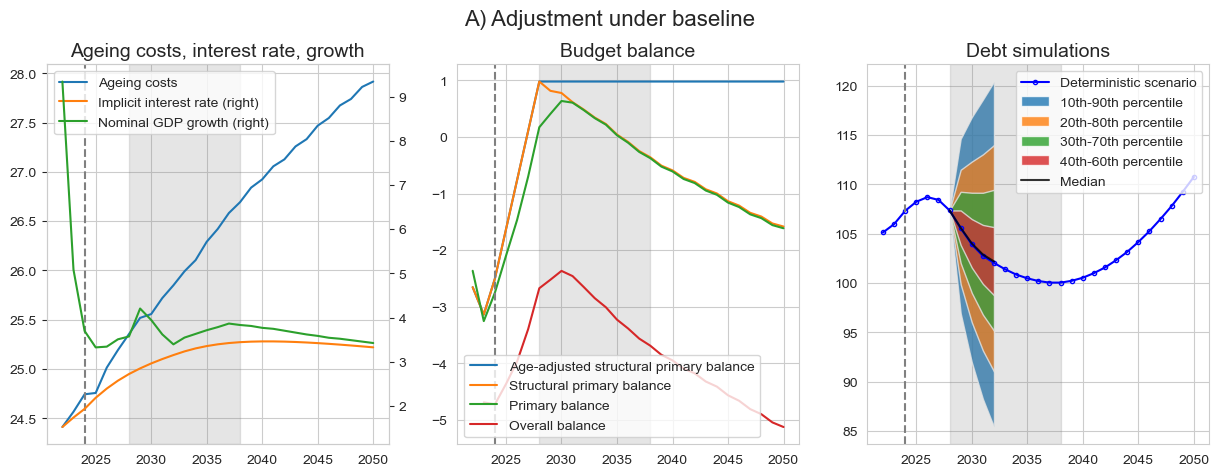

In [28]:
fig2_chart_dict = calc_fig2(results_dict)
plot_save_fig2(fig2_chart_dict, output_path, today)

### Figure 3: Minimum adjustment required for France, 7-year adjustment period (% of GDP) 

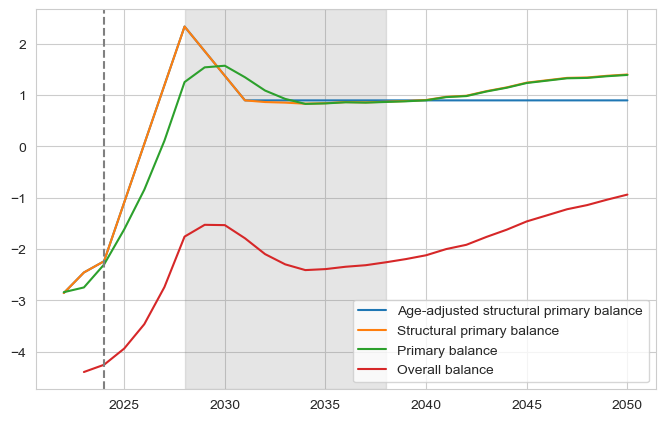

In [30]:
plot_save_fig3(results_dict, output_path, today)

### Annex 3: Graphical representation of economic assumptions and fiscal paths implied by the European Commission proposal 

In [32]:
chart_dict = calc_annex_charts(results_dict)
plot_save_annex_charts(chart_dict, output_path, eu_code_dict, today)